# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

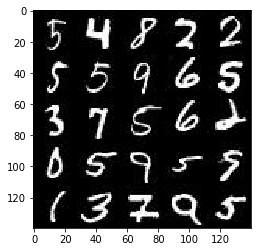

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

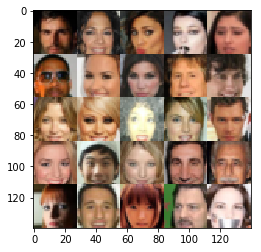

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [111]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [112]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images_ = tf.placeholder(name="real_images", dtype=tf.float32, shape=(None, image_height, image_width, image_channels))
    z_ = tf.placeholder(name="z", dtype=tf.float32, shape=(None, z_dim))
    learning_rate_ = tf.placeholder(name="learning_rate", dtype=tf.float32, shape=())

    return real_input_images_, z_, learning_rate_


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [113]:
# my lrelu function that I can reuse elsewhere
def lrelu(alpha):
    def func(x):
        return tf.maximum(alpha * x, x)
    return func

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [114]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    def convolution(inputs, numfeaturemaps, kernelsz, stridesz, activation=None, padding="SAME"):
        result = tf.layers.conv2d(inputs, numfeaturemaps, (kernelsz, kernelsz), (stridesz, stridesz), padding=padding)
        if activation is not None:
            result = activation(result)
        return result

    with tf.variable_scope("discriminator", reuse=reuse):
        conv1 = convolution(images, 64, 5, 2, activation=lrelu(0.2), padding="SAME")
        
        conv2 = convolution(conv1, 128, 5, 2, activation=None, padding="SAME")
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = lrelu(0.2)(conv2)
        
        conv3 = convolution(conv2, 256, 7, 1, activation=lrelu(0.2), padding="VALID")
        # no dropout?? WHY???
        fc3 = tf.reshape(conv3, [-1, 256])
        fc4 = tf.layers.dense(fc3, 256, activation=lrelu(0.2))
        logits = tf.layers.dense(fc4, 1, activation=None)
        output = tf.sigmoid(logits)
        

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [115]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    alpha = 0.2 # less 3 vid 6 @1:16
    # TODO: Implement Function
    # Let's go 7->14->28
    with tf.variable_scope("generator", reuse=not is_train) as scope:
        x1 = tf.layers.dense(z, 7*7*256, activation=None)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = lrelu(0.2)(x1)

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, activation=None, strides=2, padding="same")
        x2 = lrelu(0.2)(x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, activation=None, strides=2, padding="same")
        x3 = lrelu(0.2)(x3)

        x4 = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, activation=tf.tanh, strides=1, padding="same")
    
    return x4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [116]:
def model_loss(input_real, input_z, output_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, output_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth_factor = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(1.0-smooth_factor) * tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [117]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [118]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [134]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    import time
    out_channel_dim = data_shape[3]
    input_real_, input_z_, lr_ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real_, input_z_, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr_, beta1)
    total_sz = 60000 if data_shape[3] == 1 else 202599 # total hack based on the fact that this is an assignment.
    total_batches = total_sz // batch_size + (1 if total_sz % batch_size != 0 else 0)
    start = time.time()
    
    with tf.Session() as sess:
        idx = 0
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_i, batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model
                batch_images = -1 + 2 * (batch_images - batch_images.min()) / (batch_images.max() - batch_images.min())
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) # scale to -1..1
                _, dl = sess.run([d_opt, d_loss], feed_dict={input_real_: batch_images, input_z_: batch_z, lr_: learning_rate})

                # Optimize the generator twice per epoch (only once for the discriminator.)
                _, gl1 = sess.run([g_opt, g_loss], feed_dict={input_real_: batch_images, input_z_: batch_z, lr_: learning_rate})
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) # scale to -1..1
                _, gl2 = sess.run([g_opt, g_loss], feed_dict={input_real_: batch_images, input_z_: batch_z, lr_: learning_rate})
                
                gl = (gl1+gl2)/2.0
                
                idx += 1
                if idx % 16 == 0:
                    now = time.time()
                    elapsed = now - start
                    total = epoch_count * total_batches
                    left = total - idx
                    eta = now + left * elapsed / idx
                    rate = idx / elapsed
                    print("%s: Epoch: %d batch_i: %d d_loss=%.7f g_loss=%.7f rate=%.7fbatches/s" % (time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(eta)), epoch_i, batch_i, dl, gl, rate))
                if idx % 64 == 0:
                    show_generator_output(sess, 25, input_z_, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

2017-08-07 05:33:34: Epoch: 0 batch_i: 15 d_loss=1.1009078 g_loss=0.9513668 rate=5.2635159batches/s
2017-08-07 05:33:12: Epoch: 0 batch_i: 31 d_loss=1.2234852 g_loss=0.8062426 rate=5.5107034batches/s
2017-08-07 05:33:05: Epoch: 0 batch_i: 47 d_loss=1.3566029 g_loss=0.9734977 rate=5.6010647batches/s
2017-08-07 05:33:02: Epoch: 0 batch_i: 63 d_loss=1.4072838 g_loss=1.1487244 rate=5.6411191batches/s


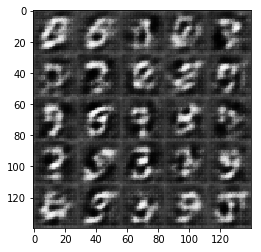

2017-08-07 05:33:08: Epoch: 0 batch_i: 79 d_loss=1.2889197 g_loss=1.2726935 rate=5.5562992batches/s
2017-08-07 05:33:05: Epoch: 0 batch_i: 95 d_loss=1.2135363 g_loss=1.2271186 rate=5.5983365batches/s
2017-08-07 05:33:03: Epoch: 0 batch_i: 111 d_loss=1.2586381 g_loss=1.1878960 rate=5.6220277batches/s
2017-08-07 05:33:03: Epoch: 0 batch_i: 127 d_loss=1.1321902 g_loss=1.2269620 rate=5.6305417batches/s


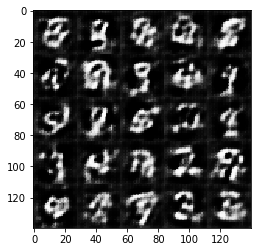

2017-08-07 05:33:19: Epoch: 0 batch_i: 143 d_loss=1.1200798 g_loss=1.1201674 rate=5.4258849batches/s
2017-08-07 05:33:18: Epoch: 0 batch_i: 159 d_loss=1.1068351 g_loss=1.3840185 rate=5.4390911batches/s
2017-08-07 05:33:17: Epoch: 0 batch_i: 175 d_loss=1.2597644 g_loss=1.2777048 rate=5.4553237batches/s
2017-08-07 05:33:16: Epoch: 0 batch_i: 191 d_loss=1.0856624 g_loss=1.3144207 rate=5.4647844batches/s


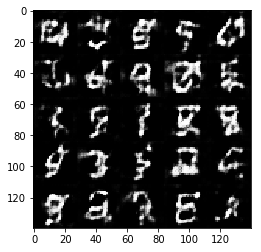

2017-08-07 05:33:20: Epoch: 0 batch_i: 207 d_loss=1.1533506 g_loss=1.4246690 rate=5.4144709batches/s
2017-08-07 05:33:19: Epoch: 0 batch_i: 223 d_loss=1.0677177 g_loss=0.9939177 rate=5.4267402batches/s
2017-08-07 05:33:18: Epoch: 0 batch_i: 239 d_loss=1.1508284 g_loss=1.5241512 rate=5.4392007batches/s
2017-08-07 05:33:17: Epoch: 0 batch_i: 255 d_loss=1.1749506 g_loss=0.8973387 rate=5.4502546batches/s


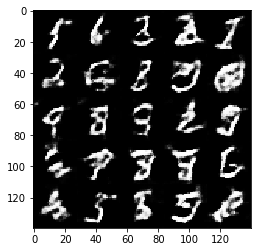

2017-08-07 05:33:20: Epoch: 0 batch_i: 271 d_loss=1.1803427 g_loss=1.1290905 rate=5.4171462batches/s
2017-08-07 05:33:19: Epoch: 0 batch_i: 287 d_loss=1.2116601 g_loss=1.2706771 rate=5.4297435batches/s
2017-08-07 05:33:18: Epoch: 0 batch_i: 303 d_loss=1.1797574 g_loss=1.3513987 rate=5.4413917batches/s
2017-08-07 05:33:17: Epoch: 0 batch_i: 319 d_loss=1.2102293 g_loss=1.1848977 rate=5.4529388batches/s


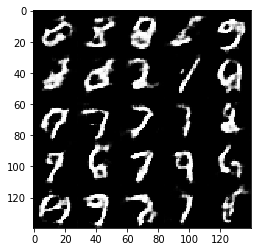

2017-08-07 05:33:19: Epoch: 0 batch_i: 335 d_loss=1.1572300 g_loss=1.3473656 rate=5.4256597batches/s
2017-08-07 05:33:19: Epoch: 0 batch_i: 351 d_loss=1.1651253 g_loss=1.5088944 rate=5.4344321batches/s
2017-08-07 05:33:18: Epoch: 0 batch_i: 367 d_loss=1.1787789 g_loss=1.2868783 rate=5.4443286batches/s
2017-08-07 05:33:19: Epoch: 0 batch_i: 383 d_loss=1.2593293 g_loss=1.1956791 rate=5.4241368batches/s


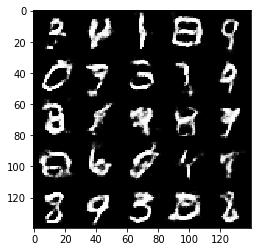

2017-08-07 05:33:52: Epoch: 0 batch_i: 399 d_loss=1.1973499 g_loss=1.1276720 rate=5.0682815batches/s
2017-08-07 05:34:28: Epoch: 0 batch_i: 415 d_loss=1.1699938 g_loss=1.1796793 rate=4.7256461batches/s
2017-08-07 05:35:22: Epoch: 0 batch_i: 431 d_loss=1.1738871 g_loss=1.4051579 rate=4.2829740batches/s
2017-08-07 05:35:48: Epoch: 0 batch_i: 447 d_loss=1.1459054 g_loss=1.1428555 rate=4.1020570batches/s


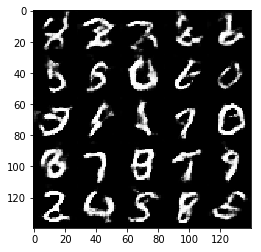

2017-08-07 05:36:18: Epoch: 0 batch_i: 463 d_loss=1.1275153 g_loss=1.4709797 rate=3.9115539batches/s
2017-08-07 05:37:02: Epoch: 0 batch_i: 479 d_loss=1.1634080 g_loss=1.2878932 rate=3.6600544batches/s
2017-08-07 05:37:39: Epoch: 0 batch_i: 495 d_loss=1.1332155 g_loss=1.1528186 rate=3.4724044batches/s
2017-08-07 05:38:00: Epoch: 0 batch_i: 511 d_loss=1.0852643 g_loss=1.4540048 rate=3.3732955batches/s


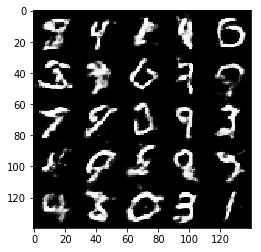

2017-08-07 05:38:17: Epoch: 0 batch_i: 527 d_loss=1.2978250 g_loss=1.2356975 rate=3.2967257batches/s
2017-08-07 05:38:29: Epoch: 0 batch_i: 543 d_loss=1.2487085 g_loss=1.4320660 rate=3.2456294batches/s
2017-08-07 05:38:42: Epoch: 0 batch_i: 559 d_loss=1.1840037 g_loss=1.1742074 rate=3.1904591batches/s
2017-08-07 05:38:59: Epoch: 0 batch_i: 575 d_loss=1.1363969 g_loss=1.7292907 rate=3.1222005batches/s


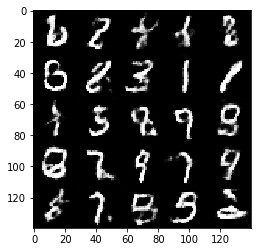

2017-08-07 05:39:15: Epoch: 0 batch_i: 591 d_loss=1.1284539 g_loss=1.3015234 rate=3.0633294batches/s
2017-08-07 05:39:26: Epoch: 0 batch_i: 607 d_loss=1.1988200 g_loss=1.3063481 rate=3.0230222batches/s
2017-08-07 05:39:35: Epoch: 0 batch_i: 623 d_loss=1.1052268 g_loss=1.4581974 rate=2.9899564batches/s
2017-08-07 05:39:44: Epoch: 0 batch_i: 639 d_loss=1.0460615 g_loss=1.5177817 rate=2.9575140batches/s


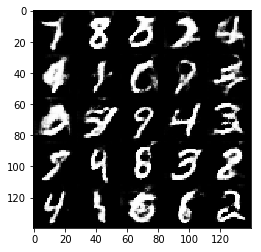

2017-08-07 05:39:52: Epoch: 0 batch_i: 655 d_loss=1.1908352 g_loss=1.4176420 rate=2.9293757batches/s
2017-08-07 05:40:05: Epoch: 0 batch_i: 671 d_loss=1.1599665 g_loss=1.2666144 rate=2.8858163batches/s
2017-08-07 05:40:11: Epoch: 0 batch_i: 687 d_loss=1.1851534 g_loss=1.3682519 rate=2.8661511batches/s
2017-08-07 05:40:23: Epoch: 0 batch_i: 703 d_loss=1.1066506 g_loss=1.4176731 rate=2.8253355batches/s


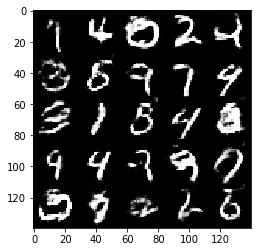

2017-08-07 05:40:31: Epoch: 0 batch_i: 719 d_loss=1.2630601 g_loss=2.1559758 rate=2.8024487batches/s
2017-08-07 05:40:40: Epoch: 0 batch_i: 735 d_loss=1.1295977 g_loss=1.1720319 rate=2.7733838batches/s
2017-08-07 05:40:52: Epoch: 0 batch_i: 751 d_loss=1.1678717 g_loss=1.2662253 rate=2.7361517batches/s
2017-08-07 05:40:58: Epoch: 0 batch_i: 767 d_loss=1.0728083 g_loss=1.5893991 rate=2.7193889batches/s


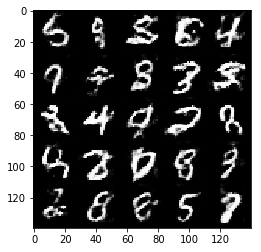

2017-08-07 05:41:04: Epoch: 0 batch_i: 783 d_loss=1.3239989 g_loss=1.1793391 rate=2.7023959batches/s
2017-08-07 05:41:19: Epoch: 0 batch_i: 799 d_loss=1.0864352 g_loss=1.4446640 rate=2.6583285batches/s
2017-08-07 05:41:28: Epoch: 0 batch_i: 815 d_loss=1.2097132 g_loss=1.6757572 rate=2.6344072batches/s
2017-08-07 05:41:32: Epoch: 0 batch_i: 831 d_loss=1.0846150 g_loss=1.4048355 rate=2.6213411batches/s


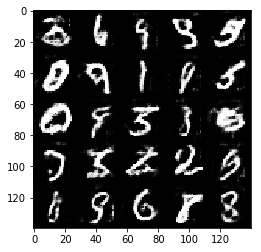

2017-08-07 05:41:43: Epoch: 0 batch_i: 847 d_loss=1.3052323 g_loss=1.2041399 rate=2.5927907batches/s
2017-08-07 05:41:48: Epoch: 0 batch_i: 863 d_loss=1.2858949 g_loss=1.3300653 rate=2.5797156batches/s
2017-08-07 05:41:54: Epoch: 0 batch_i: 879 d_loss=1.1713783 g_loss=1.3804711 rate=2.5619733batches/s
2017-08-07 05:42:01: Epoch: 0 batch_i: 895 d_loss=1.0317725 g_loss=1.3308005 rate=2.5434458batches/s


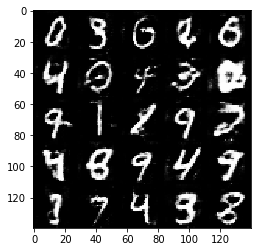

2017-08-07 05:42:07: Epoch: 0 batch_i: 911 d_loss=1.2509301 g_loss=1.4561703 rate=2.5297698batches/s
2017-08-07 05:42:10: Epoch: 0 batch_i: 927 d_loss=1.0766859 g_loss=1.1553864 rate=2.5211045batches/s
2017-08-07 05:42:19: Epoch: 0 batch_i: 943 d_loss=1.0405514 g_loss=1.5359203 rate=2.4995329batches/s
2017-08-07 05:42:22: Epoch: 0 batch_i: 959 d_loss=1.0424166 g_loss=1.3190144 rate=2.4918307batches/s


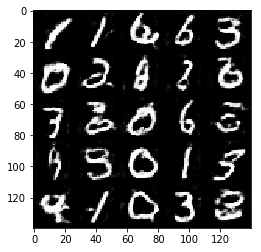

2017-08-07 05:42:26: Epoch: 0 batch_i: 975 d_loss=1.1169635 g_loss=1.2180214 rate=2.4821386batches/s
2017-08-07 05:42:32: Epoch: 0 batch_i: 991 d_loss=1.0739728 g_loss=1.1964898 rate=2.4675677batches/s
2017-08-07 05:42:34: Epoch: 0 batch_i: 1007 d_loss=1.1582981 g_loss=1.4502945 rate=2.4630013batches/s
2017-08-07 05:42:38: Epoch: 0 batch_i: 1023 d_loss=1.1389966 g_loss=1.4928288 rate=2.4523003batches/s


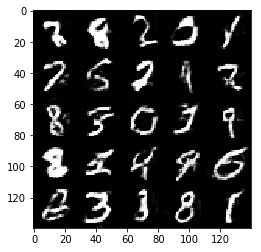

2017-08-07 05:42:55: Epoch: 0 batch_i: 1039 d_loss=1.0570970 g_loss=1.4205217 rate=2.4122952batches/s
2017-08-07 05:42:59: Epoch: 0 batch_i: 1055 d_loss=1.1846021 g_loss=1.1691531 rate=2.4017681batches/s
2017-08-07 05:43:09: Epoch: 0 batch_i: 1071 d_loss=1.1637577 g_loss=1.4195852 rate=2.3796978batches/s
2017-08-07 05:43:11: Epoch: 0 batch_i: 1087 d_loss=1.1948873 g_loss=1.3663802 rate=2.3746628batches/s


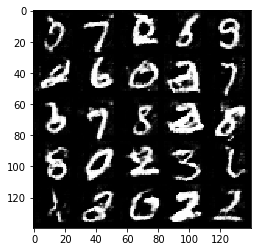

2017-08-07 05:43:15: Epoch: 0 batch_i: 1103 d_loss=1.1615527 g_loss=1.3279763 rate=2.3663189batches/s
2017-08-07 05:43:18: Epoch: 0 batch_i: 1119 d_loss=1.3044264 g_loss=1.1464612 rate=2.3595779batches/s
2017-08-07 05:43:25: Epoch: 0 batch_i: 1135 d_loss=1.1482289 g_loss=1.2788684 rate=2.3446050batches/s
2017-08-07 05:43:27: Epoch: 0 batch_i: 1151 d_loss=1.0525641 g_loss=1.2328240 rate=2.3409245batches/s


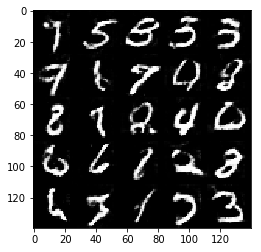

2017-08-07 05:43:30: Epoch: 0 batch_i: 1167 d_loss=1.0877434 g_loss=1.9521985 rate=2.3332775batches/s
2017-08-07 05:43:35: Epoch: 0 batch_i: 1183 d_loss=1.1967549 g_loss=1.2961392 rate=2.3226862batches/s
2017-08-07 05:43:41: Epoch: 0 batch_i: 1199 d_loss=1.1010342 g_loss=1.6324356 rate=2.3089917batches/s
2017-08-07 05:43:54: Epoch: 0 batch_i: 1215 d_loss=1.3561147 g_loss=1.3396847 rate=2.2817126batches/s


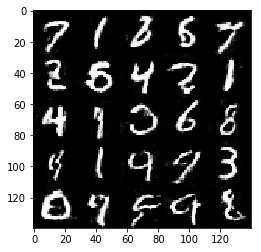

2017-08-07 05:43:57: Epoch: 0 batch_i: 1231 d_loss=1.1540310 g_loss=1.7653649 rate=2.2751619batches/s
2017-08-07 05:43:58: Epoch: 0 batch_i: 1247 d_loss=1.1630985 g_loss=1.2258440 rate=2.2731950batches/s
2017-08-07 05:43:51: Epoch: 1 batch_i: 13 d_loss=1.1154840 g_loss=1.5028841 rate=2.2885068batches/s
2017-08-07 05:43:43: Epoch: 1 batch_i: 29 d_loss=1.1138260 g_loss=1.4603510 rate=2.3059613batches/s


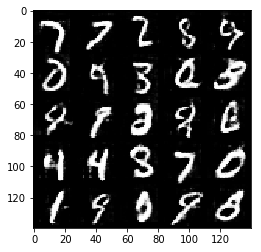

2017-08-07 05:43:35: Epoch: 1 batch_i: 45 d_loss=1.0759349 g_loss=1.4803113 rate=2.3220730batches/s
2017-08-07 05:43:27: Epoch: 1 batch_i: 61 d_loss=1.1274261 g_loss=1.5837423 rate=2.3390418batches/s
2017-08-07 05:43:20: Epoch: 1 batch_i: 77 d_loss=1.2085435 g_loss=1.8659956 rate=2.3543142batches/s
2017-08-07 05:43:15: Epoch: 1 batch_i: 93 d_loss=0.9963318 g_loss=1.3945093 rate=2.3674717batches/s


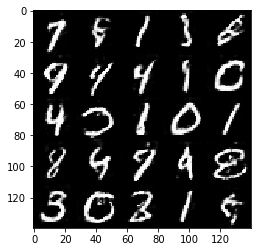

2017-08-07 05:43:08: Epoch: 1 batch_i: 109 d_loss=1.1640255 g_loss=1.2997905 rate=2.3821505batches/s
2017-08-07 05:43:01: Epoch: 1 batch_i: 125 d_loss=1.1093956 g_loss=1.2631943 rate=2.3972633batches/s
2017-08-07 05:42:55: Epoch: 1 batch_i: 141 d_loss=1.0980256 g_loss=1.6959066 rate=2.4129061batches/s
2017-08-07 05:42:48: Epoch: 1 batch_i: 157 d_loss=1.2215438 g_loss=1.6147337 rate=2.4283324batches/s


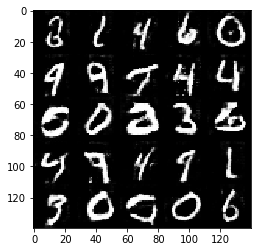

2017-08-07 05:42:42: Epoch: 1 batch_i: 173 d_loss=1.0860994 g_loss=1.7197576 rate=2.4418802batches/s
2017-08-07 05:42:36: Epoch: 1 batch_i: 189 d_loss=1.3198676 g_loss=1.3346357 rate=2.4563316batches/s
2017-08-07 05:42:30: Epoch: 1 batch_i: 205 d_loss=0.9946250 g_loss=1.5293990 rate=2.4706307batches/s
2017-08-07 05:42:24: Epoch: 1 batch_i: 221 d_loss=1.0645390 g_loss=1.5417302 rate=2.4855585batches/s


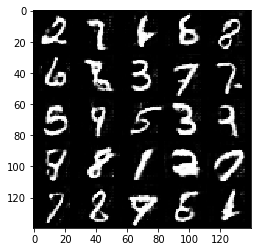

2017-08-07 05:42:19: Epoch: 1 batch_i: 237 d_loss=1.1160560 g_loss=1.5760603 rate=2.4988223batches/s
2017-08-07 05:42:13: Epoch: 1 batch_i: 253 d_loss=1.2033079 g_loss=1.8542717 rate=2.5131388batches/s
2017-08-07 05:42:08: Epoch: 1 batch_i: 269 d_loss=1.1042029 g_loss=1.4136854 rate=2.5263376batches/s
2017-08-07 05:42:03: Epoch: 1 batch_i: 285 d_loss=1.0475252 g_loss=1.7395499 rate=2.5383913batches/s


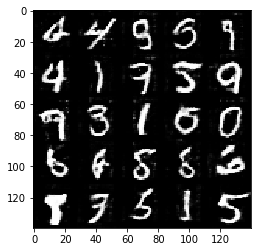

2017-08-07 05:41:59: Epoch: 1 batch_i: 301 d_loss=1.1227179 g_loss=1.1293954 rate=2.5506988batches/s
2017-08-07 05:41:53: Epoch: 1 batch_i: 317 d_loss=0.9637095 g_loss=1.6235191 rate=2.5651979batches/s
2017-08-07 05:41:48: Epoch: 1 batch_i: 333 d_loss=1.2259072 g_loss=1.2219307 rate=2.5796804batches/s
2017-08-07 05:41:42: Epoch: 1 batch_i: 349 d_loss=1.1122316 g_loss=1.4465743 rate=2.5939847batches/s


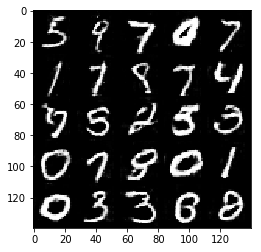

2017-08-07 05:41:38: Epoch: 1 batch_i: 365 d_loss=0.9934209 g_loss=1.5441833 rate=2.6066662batches/s
2017-08-07 05:41:32: Epoch: 1 batch_i: 381 d_loss=1.1659238 g_loss=1.6876969 rate=2.6208235batches/s
2017-08-07 05:41:34: Epoch: 1 batch_i: 397 d_loss=1.2338595 g_loss=1.5514982 rate=2.6158421batches/s
2017-08-07 05:41:37: Epoch: 1 batch_i: 413 d_loss=1.1333754 g_loss=1.5174232 rate=2.6089155batches/s


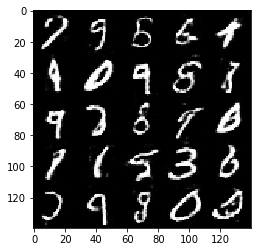

2017-08-07 05:41:41: Epoch: 1 batch_i: 429 d_loss=1.0192095 g_loss=1.7138720 rate=2.5975404batches/s
2017-08-07 05:41:42: Epoch: 1 batch_i: 445 d_loss=1.1262519 g_loss=2.0312228 rate=2.5951300batches/s
2017-08-07 05:41:43: Epoch: 1 batch_i: 461 d_loss=1.2270235 g_loss=1.1361634 rate=2.5916802batches/s
2017-08-07 05:41:47: Epoch: 1 batch_i: 477 d_loss=1.1974396 g_loss=1.5330781 rate=2.5805439batches/s


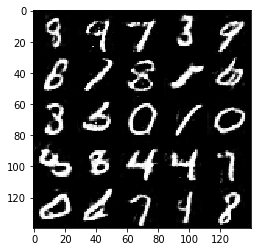

2017-08-07 05:41:49: Epoch: 1 batch_i: 493 d_loss=0.9730262 g_loss=1.6505945 rate=2.5761502batches/s
2017-08-07 05:41:46: Epoch: 1 batch_i: 509 d_loss=0.9907830 g_loss=1.6202565 rate=2.5850191batches/s
2017-08-07 05:41:41: Epoch: 1 batch_i: 525 d_loss=1.1371640 g_loss=1.3163002 rate=2.5979558batches/s
2017-08-07 05:41:38: Epoch: 1 batch_i: 541 d_loss=1.0826176 g_loss=1.5695155 rate=2.6069731batches/s


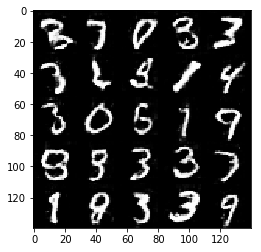

2017-08-07 05:41:34: Epoch: 1 batch_i: 557 d_loss=1.1856674 g_loss=1.5104611 rate=2.6173949batches/s
2017-08-07 05:41:30: Epoch: 1 batch_i: 573 d_loss=1.1160830 g_loss=1.6680288 rate=2.6283669batches/s
2017-08-07 05:41:27: Epoch: 1 batch_i: 589 d_loss=1.2665818 g_loss=1.1504784 rate=2.6370206batches/s
2017-08-07 05:41:22: Epoch: 1 batch_i: 605 d_loss=1.0805774 g_loss=1.3834925 rate=2.6485918batches/s


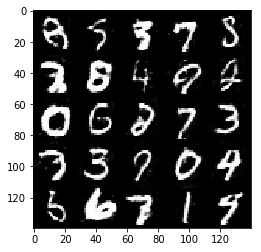

2017-08-07 05:41:19: Epoch: 1 batch_i: 621 d_loss=0.9933552 g_loss=1.7647514 rate=2.6577993batches/s
2017-08-07 05:41:15: Epoch: 1 batch_i: 637 d_loss=1.0224290 g_loss=1.7589796 rate=2.6696850batches/s
2017-08-07 05:41:11: Epoch: 1 batch_i: 653 d_loss=1.1128972 g_loss=2.0481503 rate=2.6815010batches/s
2017-08-07 05:41:07: Epoch: 1 batch_i: 669 d_loss=1.2234294 g_loss=1.2783076 rate=2.6932260batches/s


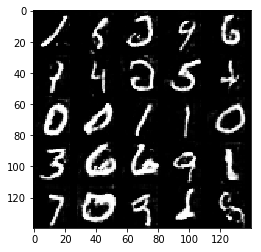

2017-08-07 05:41:03: Epoch: 1 batch_i: 685 d_loss=1.1037298 g_loss=1.5537084 rate=2.7029922batches/s
2017-08-07 05:41:00: Epoch: 1 batch_i: 701 d_loss=1.0595684 g_loss=1.5031366 rate=2.7145172batches/s
2017-08-07 05:40:56: Epoch: 1 batch_i: 717 d_loss=1.0476823 g_loss=1.5132318 rate=2.7258685batches/s
2017-08-07 05:40:52: Epoch: 1 batch_i: 733 d_loss=0.9844208 g_loss=1.4893911 rate=2.7371794batches/s


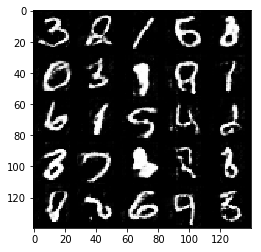

2017-08-07 05:40:49: Epoch: 1 batch_i: 749 d_loss=1.0817784 g_loss=1.4962759 rate=2.7465231batches/s
2017-08-07 05:40:45: Epoch: 1 batch_i: 765 d_loss=1.0144590 g_loss=1.3423392 rate=2.7576330batches/s
2017-08-07 05:40:42: Epoch: 1 batch_i: 781 d_loss=0.9838797 g_loss=1.8322232 rate=2.7686053batches/s
2017-08-07 05:40:38: Epoch: 1 batch_i: 797 d_loss=1.1191719 g_loss=1.6098359 rate=2.7795787batches/s


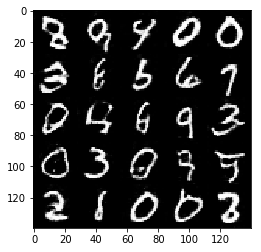

2017-08-07 05:40:35: Epoch: 1 batch_i: 813 d_loss=1.8766594 g_loss=1.7602532 rate=2.7886523batches/s
2017-08-07 05:40:32: Epoch: 1 batch_i: 829 d_loss=1.0870427 g_loss=1.7021378 rate=2.7994811batches/s
2017-08-07 05:40:28: Epoch: 1 batch_i: 845 d_loss=1.1568289 g_loss=1.5122650 rate=2.8102073batches/s
2017-08-07 05:40:25: Epoch: 1 batch_i: 861 d_loss=1.0589396 g_loss=1.4360523 rate=2.8187651batches/s


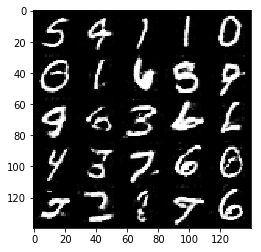

2017-08-07 05:40:23: Epoch: 1 batch_i: 877 d_loss=0.9671055 g_loss=1.4506156 rate=2.8274664batches/s
2017-08-07 05:40:19: Epoch: 1 batch_i: 893 d_loss=1.1559378 g_loss=1.7303312 rate=2.8379900batches/s
2017-08-07 05:40:16: Epoch: 1 batch_i: 909 d_loss=1.1252311 g_loss=1.1875000 rate=2.8484396batches/s
2017-08-07 05:40:13: Epoch: 1 batch_i: 925 d_loss=1.0846159 g_loss=1.9143785 rate=2.8586437batches/s


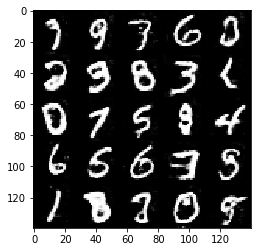

2017-08-07 05:40:11: Epoch: 1 batch_i: 941 d_loss=0.9813052 g_loss=1.3990364 rate=2.8669588batches/s
2017-08-07 05:40:07: Epoch: 1 batch_i: 957 d_loss=0.9608811 g_loss=1.4306229 rate=2.8770666batches/s
2017-08-07 05:40:04: Epoch: 1 batch_i: 973 d_loss=1.3340750 g_loss=1.7134435 rate=2.8871547batches/s
2017-08-07 05:40:01: Epoch: 1 batch_i: 989 d_loss=1.1881042 g_loss=1.9108118 rate=2.8971039batches/s


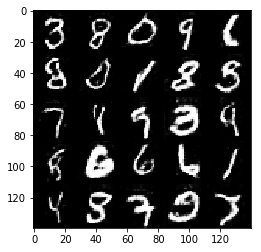

2017-08-07 05:39:59: Epoch: 1 batch_i: 1005 d_loss=1.0943077 g_loss=1.9476265 rate=2.9053178batches/s
2017-08-07 05:39:56: Epoch: 1 batch_i: 1021 d_loss=1.0801820 g_loss=2.0442829 rate=2.9151873batches/s
2017-08-07 05:39:53: Epoch: 1 batch_i: 1037 d_loss=0.8893023 g_loss=1.5729560 rate=2.9249449batches/s
2017-08-07 05:39:50: Epoch: 1 batch_i: 1053 d_loss=1.1801083 g_loss=1.8195326 rate=2.9346893batches/s


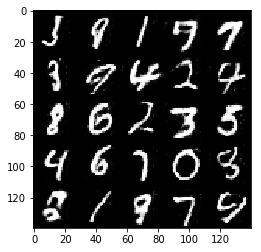

2017-08-07 05:39:48: Epoch: 1 batch_i: 1069 d_loss=0.9754923 g_loss=1.4739963 rate=2.9425646batches/s
2017-08-07 05:39:45: Epoch: 1 batch_i: 1085 d_loss=1.0302012 g_loss=1.5653414 rate=2.9521692batches/s
2017-08-07 05:39:43: Epoch: 1 batch_i: 1101 d_loss=1.0811580 g_loss=1.9823642 rate=2.9616920batches/s
2017-08-07 05:39:40: Epoch: 1 batch_i: 1117 d_loss=0.9833797 g_loss=1.6674392 rate=2.9711472batches/s


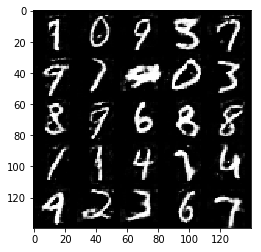

2017-08-07 05:39:38: Epoch: 1 batch_i: 1133 d_loss=1.5293286 g_loss=0.8513956 rate=2.9787559batches/s
2017-08-07 05:39:35: Epoch: 1 batch_i: 1149 d_loss=1.1477501 g_loss=1.3221064 rate=2.9879884batches/s
2017-08-07 05:39:33: Epoch: 1 batch_i: 1165 d_loss=1.0578218 g_loss=1.7495286 rate=2.9972236batches/s
2017-08-07 05:39:31: Epoch: 1 batch_i: 1181 d_loss=1.0624211 g_loss=1.9042141 rate=3.0043522batches/s


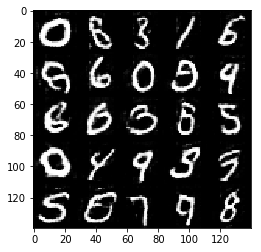

2017-08-07 05:39:29: Epoch: 1 batch_i: 1197 d_loss=1.0142365 g_loss=1.7605110 rate=3.0117168batches/s
2017-08-07 05:39:26: Epoch: 1 batch_i: 1213 d_loss=1.1393652 g_loss=1.6955774 rate=3.0207497batches/s
2017-08-07 05:39:24: Epoch: 1 batch_i: 1229 d_loss=1.1457518 g_loss=1.8665965 rate=3.0298161batches/s
2017-08-07 05:39:21: Epoch: 1 batch_i: 1245 d_loss=1.0274016 g_loss=1.5282891 rate=3.0387716batches/s


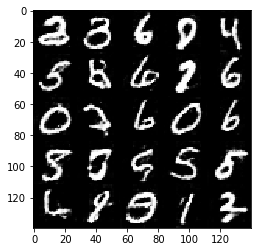

In [135]:
batch_size = 48
z_dim = 100
learning_rate = 0.00025
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

2017-08-07 06:33:40: Epoch: 0 batch_i: 15 d_loss=1.1901259 g_loss=0.9236829 rate=1.2985637batches/s
2017-08-07 06:29:36: Epoch: 0 batch_i: 31 d_loss=1.3449662 g_loss=1.6182356 rate=1.4037044batches/s
2017-08-07 06:26:29: Epoch: 0 batch_i: 47 d_loss=1.3814015 g_loss=1.0436382 rate=1.4970342batches/s
2017-08-07 06:29:24: Epoch: 0 batch_i: 63 d_loss=1.2466526 g_loss=1.1355758 rate=1.4094237batches/s


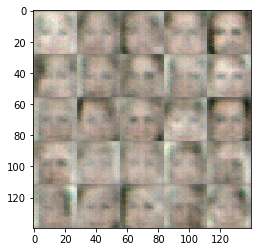

2017-08-07 06:29:31: Epoch: 0 batch_i: 79 d_loss=1.5400064 g_loss=1.1650698 rate=1.4060261batches/s
2017-08-07 06:28:35: Epoch: 0 batch_i: 95 d_loss=1.4114313 g_loss=0.7876673 rate=1.4329872batches/s
2017-08-07 06:28:29: Epoch: 0 batch_i: 111 d_loss=1.3271967 g_loss=1.0131115 rate=1.4356923batches/s
2017-08-07 06:27:40: Epoch: 0 batch_i: 127 d_loss=1.3360775 g_loss=1.0031304 rate=1.4598450batches/s


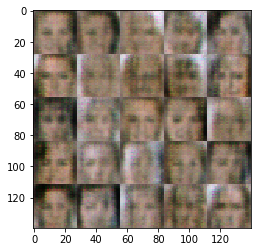

2017-08-07 06:27:15: Epoch: 0 batch_i: 143 d_loss=1.2883577 g_loss=1.0185509 rate=1.4728164batches/s
2017-08-07 06:26:52: Epoch: 0 batch_i: 159 d_loss=1.3936675 g_loss=0.8787095 rate=1.4848691batches/s
2017-08-07 06:26:17: Epoch: 0 batch_i: 175 d_loss=1.3927506 g_loss=0.9772276 rate=1.5033614batches/s
2017-08-07 06:27:49: Epoch: 0 batch_i: 191 d_loss=1.3947439 g_loss=0.9397131 rate=1.4556770batches/s


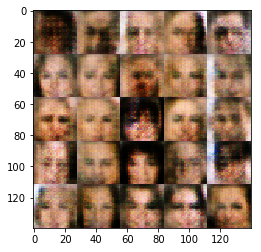

2017-08-07 06:27:25: Epoch: 0 batch_i: 207 d_loss=1.4425139 g_loss=0.9467179 rate=1.4678960batches/s
2017-08-07 06:27:02: Epoch: 0 batch_i: 223 d_loss=1.3768353 g_loss=0.9159775 rate=1.4795344batches/s
2017-08-07 06:26:36: Epoch: 0 batch_i: 239 d_loss=1.3897755 g_loss=0.9679997 rate=1.4929780batches/s
2017-08-07 06:26:25: Epoch: 0 batch_i: 255 d_loss=1.3835884 g_loss=0.9164395 rate=1.4989771batches/s


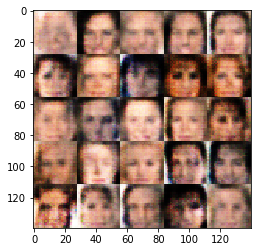

2017-08-07 06:26:07: Epoch: 0 batch_i: 271 d_loss=1.3805643 g_loss=1.0257175 rate=1.5084101batches/s
2017-08-07 06:26:09: Epoch: 0 batch_i: 287 d_loss=1.3555714 g_loss=0.9741243 rate=1.5072895batches/s
2017-08-07 06:25:47: Epoch: 0 batch_i: 303 d_loss=1.3667924 g_loss=0.8990024 rate=1.5194939batches/s
2017-08-07 06:25:20: Epoch: 0 batch_i: 319 d_loss=1.3597976 g_loss=1.0075027 rate=1.5345935batches/s


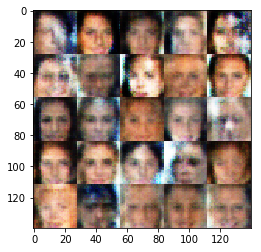

2017-08-07 06:25:36: Epoch: 0 batch_i: 335 d_loss=1.4297380 g_loss=0.9760857 rate=1.5255456batches/s
2017-08-07 06:25:31: Epoch: 0 batch_i: 351 d_loss=1.3311775 g_loss=0.9938600 rate=1.5280652batches/s
2017-08-07 06:25:10: Epoch: 0 batch_i: 367 d_loss=1.3388216 g_loss=0.9481151 rate=1.5397227batches/s
2017-08-07 06:25:18: Epoch: 0 batch_i: 383 d_loss=1.3559155 g_loss=0.9774342 rate=1.5356789batches/s


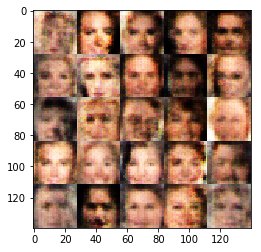

2017-08-07 06:25:18: Epoch: 0 batch_i: 399 d_loss=1.4348489 g_loss=0.9821551 rate=1.5353256batches/s
2017-08-07 06:25:05: Epoch: 0 batch_i: 415 d_loss=1.3527845 g_loss=0.9180975 rate=1.5426571batches/s
2017-08-07 06:24:54: Epoch: 0 batch_i: 431 d_loss=1.3645525 g_loss=0.8901457 rate=1.5488072batches/s
2017-08-07 06:25:35: Epoch: 0 batch_i: 447 d_loss=1.3814654 g_loss=0.9798069 rate=1.5261723batches/s


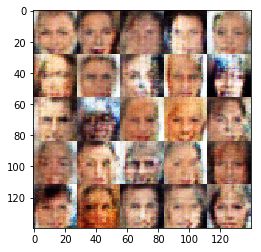

2017-08-07 06:25:30: Epoch: 0 batch_i: 463 d_loss=1.3708980 g_loss=0.8741980 rate=1.5286012batches/s
2017-08-07 06:25:26: Epoch: 0 batch_i: 479 d_loss=1.3839964 g_loss=0.8525717 rate=1.5310626batches/s
2017-08-07 06:25:19: Epoch: 0 batch_i: 495 d_loss=1.3511589 g_loss=0.8265996 rate=1.5350092batches/s
2017-08-07 06:25:21: Epoch: 0 batch_i: 511 d_loss=1.3354769 g_loss=0.8419870 rate=1.5335663batches/s


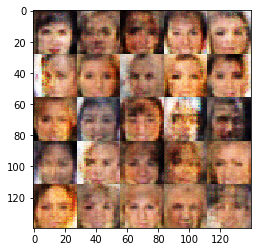

2017-08-07 06:25:18: Epoch: 0 batch_i: 527 d_loss=1.3265525 g_loss=0.9188269 rate=1.5354462batches/s
2017-08-07 06:25:04: Epoch: 0 batch_i: 543 d_loss=1.4081264 g_loss=0.8729252 rate=1.5432491batches/s
2017-08-07 06:25:05: Epoch: 0 batch_i: 559 d_loss=1.3843842 g_loss=0.8580623 rate=1.5426662batches/s
2017-08-07 06:24:58: Epoch: 0 batch_i: 575 d_loss=1.4015095 g_loss=0.9291224 rate=1.5468976batches/s


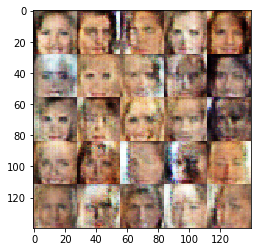

2017-08-07 06:25:26: Epoch: 0 batch_i: 591 d_loss=1.3837188 g_loss=0.8836211 rate=1.5312673batches/s
2017-08-07 06:25:12: Epoch: 0 batch_i: 607 d_loss=1.2928278 g_loss=0.8336380 rate=1.5387765batches/s
2017-08-07 06:25:11: Epoch: 0 batch_i: 623 d_loss=1.3804623 g_loss=0.8625520 rate=1.5392487batches/s
2017-08-07 06:25:01: Epoch: 0 batch_i: 639 d_loss=1.3579144 g_loss=0.8755361 rate=1.5448914batches/s


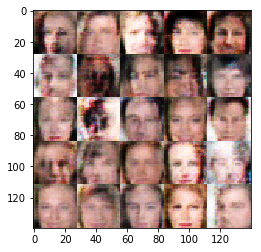

2017-08-07 06:25:00: Epoch: 0 batch_i: 655 d_loss=1.3947341 g_loss=0.8522930 rate=1.5458925batches/s
2017-08-07 06:25:26: Epoch: 0 batch_i: 671 d_loss=1.3716128 g_loss=0.8543536 rate=1.5311349batches/s
2017-08-07 06:25:24: Epoch: 0 batch_i: 687 d_loss=1.4677426 g_loss=0.8797370 rate=1.5320593batches/s
2017-08-07 06:25:19: Epoch: 0 batch_i: 703 d_loss=1.3892474 g_loss=0.8231733 rate=1.5348910batches/s


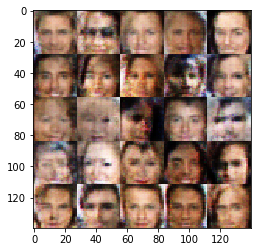

2017-08-07 06:25:12: Epoch: 0 batch_i: 719 d_loss=1.4114813 g_loss=0.8462156 rate=1.5389281batches/s
2017-08-07 06:25:14: Epoch: 0 batch_i: 735 d_loss=1.3953365 g_loss=0.9018451 rate=1.5377372batches/s
2017-08-07 06:25:04: Epoch: 0 batch_i: 751 d_loss=1.3624938 g_loss=0.9037713 rate=1.5432110batches/s
2017-08-07 06:24:58: Epoch: 0 batch_i: 767 d_loss=1.3873609 g_loss=0.8691145 rate=1.5467629batches/s


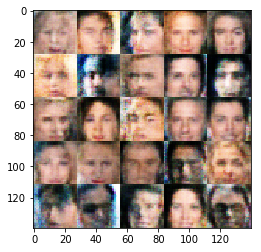

2017-08-07 06:24:52: Epoch: 0 batch_i: 783 d_loss=1.4108431 g_loss=0.8391333 rate=1.5499730batches/s
2017-08-07 06:24:45: Epoch: 0 batch_i: 799 d_loss=1.3531827 g_loss=0.8784201 rate=1.5539272batches/s
2017-08-07 06:24:40: Epoch: 0 batch_i: 815 d_loss=1.3995414 g_loss=0.8671811 rate=1.5568357batches/s
2017-08-07 06:24:41: Epoch: 0 batch_i: 831 d_loss=1.4125488 g_loss=0.8226452 rate=1.5562555batches/s


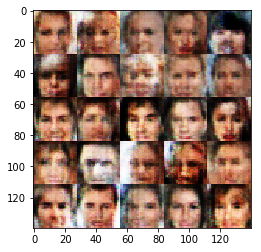

2017-08-07 06:24:35: Epoch: 0 batch_i: 847 d_loss=1.3751131 g_loss=0.8827434 rate=1.5600355batches/s
2017-08-07 06:24:36: Epoch: 0 batch_i: 863 d_loss=1.3507098 g_loss=0.9259174 rate=1.5590331batches/s
2017-08-07 06:24:36: Epoch: 0 batch_i: 879 d_loss=1.3542796 g_loss=0.8258188 rate=1.5596031batches/s
2017-08-07 06:24:55: Epoch: 0 batch_i: 895 d_loss=1.3821800 g_loss=0.8426700 rate=1.5482266batches/s


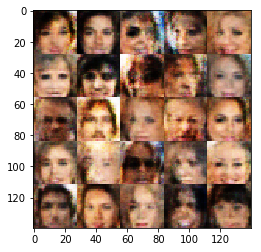

2017-08-07 06:24:58: Epoch: 0 batch_i: 911 d_loss=1.3858002 g_loss=0.8648114 rate=1.5468109batches/s
2017-08-07 06:24:51: Epoch: 0 batch_i: 927 d_loss=1.3968289 g_loss=0.8641765 rate=1.5506009batches/s
2017-08-07 06:24:46: Epoch: 0 batch_i: 943 d_loss=1.3765740 g_loss=0.8565000 rate=1.5534417batches/s
2017-08-07 06:24:55: Epoch: 0 batch_i: 959 d_loss=1.3666348 g_loss=0.8249313 rate=1.5484540batches/s


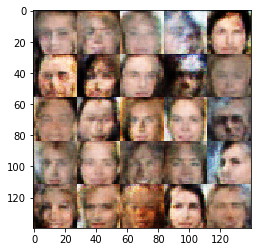

2017-08-07 06:24:50: Epoch: 0 batch_i: 975 d_loss=1.3995633 g_loss=0.8934801 rate=1.5512443batches/s
2017-08-07 06:24:46: Epoch: 0 batch_i: 991 d_loss=1.3927767 g_loss=0.8560015 rate=1.5533469batches/s
2017-08-07 06:24:44: Epoch: 0 batch_i: 1007 d_loss=1.3776288 g_loss=0.8170747 rate=1.5549673batches/s
2017-08-07 06:24:40: Epoch: 0 batch_i: 1023 d_loss=1.3508308 g_loss=0.8060949 rate=1.5570962batches/s


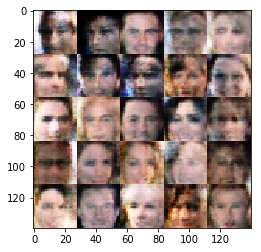

2017-08-07 06:24:41: Epoch: 0 batch_i: 1039 d_loss=1.3875947 g_loss=0.7952452 rate=1.5563722batches/s
2017-08-07 06:24:35: Epoch: 0 batch_i: 1055 d_loss=1.3329840 g_loss=0.8556471 rate=1.5598622batches/s
2017-08-07 06:24:57: Epoch: 0 batch_i: 1071 d_loss=1.3316391 g_loss=0.8420507 rate=1.5471552batches/s
2017-08-07 06:24:52: Epoch: 0 batch_i: 1087 d_loss=1.3634393 g_loss=0.8698108 rate=1.5502732batches/s


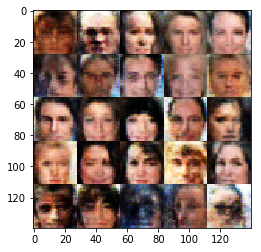

2017-08-07 06:24:53: Epoch: 0 batch_i: 1103 d_loss=1.3811142 g_loss=0.8622800 rate=1.5496567batches/s
2017-08-07 06:24:47: Epoch: 0 batch_i: 1119 d_loss=1.4152920 g_loss=0.8284038 rate=1.5531952batches/s
2017-08-07 06:24:41: Epoch: 0 batch_i: 1135 d_loss=1.3689384 g_loss=0.8244169 rate=1.5563625batches/s
2017-08-07 06:24:41: Epoch: 0 batch_i: 1151 d_loss=1.3888453 g_loss=0.8275741 rate=1.5563258batches/s


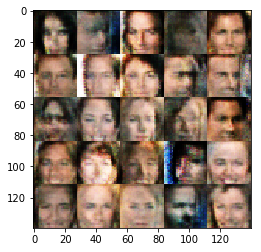

2017-08-07 06:24:38: Epoch: 0 batch_i: 1167 d_loss=1.3882815 g_loss=0.8770795 rate=1.5582392batches/s
2017-08-07 06:24:33: Epoch: 0 batch_i: 1183 d_loss=1.3835640 g_loss=0.8715391 rate=1.5608127batches/s
2017-08-07 06:24:29: Epoch: 0 batch_i: 1199 d_loss=1.3819695 g_loss=0.8903577 rate=1.5635348batches/s
2017-08-07 06:24:31: Epoch: 0 batch_i: 1215 d_loss=1.3373140 g_loss=0.8632644 rate=1.5619286batches/s


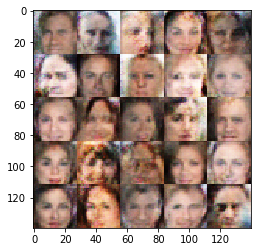

2017-08-07 06:24:38: Epoch: 0 batch_i: 1231 d_loss=1.3722413 g_loss=0.9364946 rate=1.5581329batches/s
2017-08-07 06:24:33: Epoch: 0 batch_i: 1247 d_loss=1.3659115 g_loss=0.8542877 rate=1.5611208batches/s
2017-08-07 06:24:30: Epoch: 0 batch_i: 1263 d_loss=1.3904144 g_loss=0.8580089 rate=1.5627631batches/s
2017-08-07 06:24:27: Epoch: 0 batch_i: 1279 d_loss=1.3697155 g_loss=0.8229059 rate=1.5647435batches/s


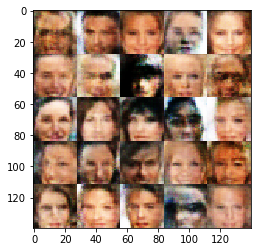

2017-08-07 06:24:23: Epoch: 0 batch_i: 1295 d_loss=1.3413780 g_loss=0.8196336 rate=1.5666595batches/s
2017-08-07 06:24:24: Epoch: 0 batch_i: 1311 d_loss=1.3983544 g_loss=0.8563702 rate=1.5660663batches/s
2017-08-07 06:24:21: Epoch: 0 batch_i: 1327 d_loss=1.3985134 g_loss=0.8629861 rate=1.5680724batches/s
2017-08-07 06:24:24: Epoch: 0 batch_i: 1343 d_loss=1.3686948 g_loss=0.8292670 rate=1.5661744batches/s


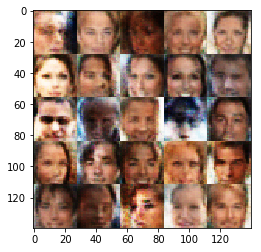

2017-08-07 06:24:26: Epoch: 0 batch_i: 1359 d_loss=1.3753111 g_loss=0.8953980 rate=1.5652817batches/s
2017-08-07 06:24:21: Epoch: 0 batch_i: 1375 d_loss=1.4071708 g_loss=0.8915097 rate=1.5679401batches/s
2017-08-07 06:24:21: Epoch: 0 batch_i: 1391 d_loss=1.4760059 g_loss=0.8402820 rate=1.5682697batches/s
2017-08-07 06:24:17: Epoch: 0 batch_i: 1407 d_loss=1.3353854 g_loss=0.8564335 rate=1.5703675batches/s


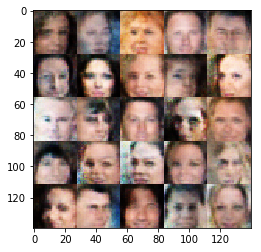

2017-08-07 06:24:14: Epoch: 0 batch_i: 1423 d_loss=1.3515580 g_loss=0.8330154 rate=1.5718665batches/s
2017-08-07 06:24:12: Epoch: 0 batch_i: 1439 d_loss=1.3734026 g_loss=0.8537983 rate=1.5732745batches/s
2017-08-07 06:24:12: Epoch: 0 batch_i: 1455 d_loss=1.3493657 g_loss=0.8612248 rate=1.5731218batches/s
2017-08-07 06:24:12: Epoch: 0 batch_i: 1471 d_loss=1.3734126 g_loss=0.8516881 rate=1.5734724batches/s


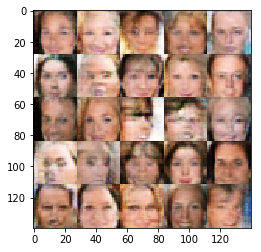

2017-08-07 06:24:10: Epoch: 0 batch_i: 1487 d_loss=1.3639226 g_loss=0.8290722 rate=1.5746686batches/s
2017-08-07 06:24:09: Epoch: 0 batch_i: 1503 d_loss=1.3869387 g_loss=0.8532168 rate=1.5748024batches/s
2017-08-07 06:24:09: Epoch: 0 batch_i: 1519 d_loss=1.3745797 g_loss=0.8683751 rate=1.5749401batches/s
2017-08-07 06:24:07: Epoch: 0 batch_i: 1535 d_loss=1.3847954 g_loss=0.8623084 rate=1.5764310batches/s


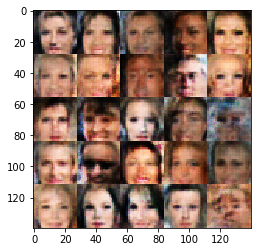

2017-08-07 06:24:07: Epoch: 0 batch_i: 1551 d_loss=1.4133958 g_loss=0.8292315 rate=1.5762458batches/s
2017-08-07 06:24:06: Epoch: 0 batch_i: 1567 d_loss=1.3979366 g_loss=0.8869691 rate=1.5765605batches/s
2017-08-07 06:24:05: Epoch: 0 batch_i: 1583 d_loss=1.3849971 g_loss=0.8562720 rate=1.5772584batches/s
2017-08-07 06:24:05: Epoch: 0 batch_i: 1599 d_loss=1.3504012 g_loss=0.8839472 rate=1.5774782batches/s


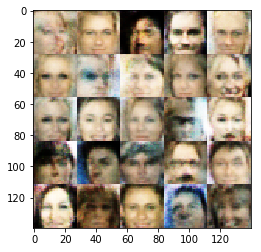

2017-08-07 06:24:02: Epoch: 0 batch_i: 1615 d_loss=1.3969926 g_loss=0.8509778 rate=1.5790463batches/s
2017-08-07 06:24:02: Epoch: 0 batch_i: 1631 d_loss=1.3276882 g_loss=0.9116942 rate=1.5788879batches/s
2017-08-07 06:24:02: Epoch: 0 batch_i: 1647 d_loss=1.3430203 g_loss=0.8356440 rate=1.5791786batches/s
2017-08-07 06:24:01: Epoch: 0 batch_i: 1663 d_loss=1.3670149 g_loss=0.8677421 rate=1.5797748batches/s


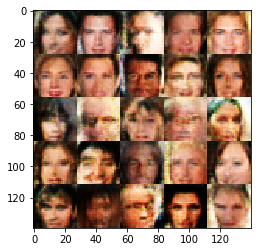

2017-08-07 06:23:59: Epoch: 0 batch_i: 1679 d_loss=1.3788285 g_loss=0.8346586 rate=1.5811801batches/s
2017-08-07 06:23:55: Epoch: 0 batch_i: 1695 d_loss=1.3824465 g_loss=0.8456545 rate=1.5835079batches/s
2017-08-07 06:23:58: Epoch: 0 batch_i: 1711 d_loss=1.3676708 g_loss=0.8773927 rate=1.5816226batches/s
2017-08-07 06:23:57: Epoch: 0 batch_i: 1727 d_loss=1.3897843 g_loss=0.8443079 rate=1.5824072batches/s


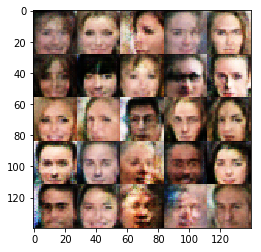

2017-08-07 06:23:53: Epoch: 0 batch_i: 1743 d_loss=1.3331158 g_loss=0.8476394 rate=1.5841907batches/s
2017-08-07 06:23:55: Epoch: 0 batch_i: 1759 d_loss=1.3585014 g_loss=0.8644284 rate=1.5835071batches/s
2017-08-07 06:23:54: Epoch: 0 batch_i: 1775 d_loss=1.4115884 g_loss=0.8021411 rate=1.5838119batches/s
2017-08-07 06:23:53: Epoch: 0 batch_i: 1791 d_loss=1.4470356 g_loss=0.8454927 rate=1.5846083batches/s


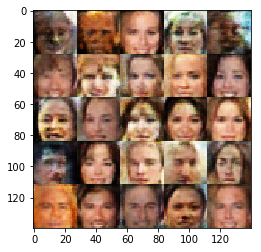

2017-08-07 06:23:54: Epoch: 0 batch_i: 1807 d_loss=1.4032677 g_loss=0.8965952 rate=1.5840600batches/s
2017-08-07 06:23:52: Epoch: 0 batch_i: 1823 d_loss=1.3863368 g_loss=0.8024908 rate=1.5849983batches/s
2017-08-07 06:23:50: Epoch: 0 batch_i: 1839 d_loss=1.3616712 g_loss=0.8516728 rate=1.5862347batches/s
2017-08-07 06:23:49: Epoch: 0 batch_i: 1855 d_loss=1.3743646 g_loss=0.8470330 rate=1.5865792batches/s


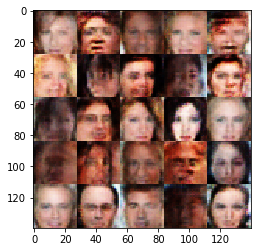

2017-08-07 06:23:50: Epoch: 0 batch_i: 1871 d_loss=1.3767130 g_loss=0.8674166 rate=1.5860502batches/s
2017-08-07 06:23:48: Epoch: 0 batch_i: 1887 d_loss=1.3943554 g_loss=0.8393239 rate=1.5873083batches/s
2017-08-07 06:23:49: Epoch: 0 batch_i: 1903 d_loss=1.4142720 g_loss=0.8424240 rate=1.5870838batches/s
2017-08-07 06:23:48: Epoch: 0 batch_i: 1919 d_loss=1.3752775 g_loss=0.8215502 rate=1.5874639batches/s


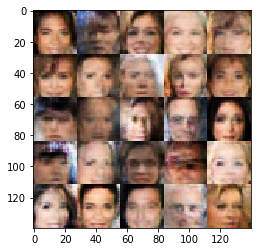

2017-08-07 06:23:48: Epoch: 0 batch_i: 1935 d_loss=1.4018437 g_loss=0.7994747 rate=1.5875200batches/s
2017-08-07 06:23:48: Epoch: 0 batch_i: 1951 d_loss=1.4211987 g_loss=0.8184367 rate=1.5873133batches/s
2017-08-07 06:24:04: Epoch: 0 batch_i: 1967 d_loss=1.3418877 g_loss=0.8678563 rate=1.5780046batches/s
2017-08-07 06:24:24: Epoch: 0 batch_i: 1983 d_loss=1.4104111 g_loss=0.8619145 rate=1.5660794batches/s


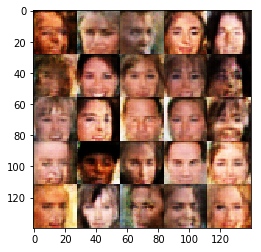

2017-08-07 06:24:45: Epoch: 0 batch_i: 1999 d_loss=1.3742770 g_loss=0.8622861 rate=1.5540270batches/s
2017-08-07 06:25:05: Epoch: 0 batch_i: 2015 d_loss=1.4178131 g_loss=0.8093305 rate=1.5427927batches/s
2017-08-07 06:25:28: Epoch: 0 batch_i: 2031 d_loss=1.3617396 g_loss=0.8142039 rate=1.5296606batches/s
2017-08-07 06:26:09: Epoch: 0 batch_i: 2047 d_loss=1.3727160 g_loss=0.8390623 rate=1.5076296batches/s


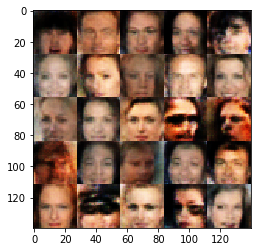

2017-08-07 06:26:20: Epoch: 0 batch_i: 2063 d_loss=1.3960896 g_loss=0.8431808 rate=1.5014799batches/s
2017-08-07 06:26:24: Epoch: 0 batch_i: 2079 d_loss=1.3688014 g_loss=0.8549767 rate=1.4995700batches/s
2017-08-07 06:26:22: Epoch: 0 batch_i: 2095 d_loss=1.3723807 g_loss=0.8481663 rate=1.5006769batches/s
2017-08-07 06:26:19: Epoch: 0 batch_i: 2111 d_loss=1.3822334 g_loss=0.8828161 rate=1.5020739batches/s


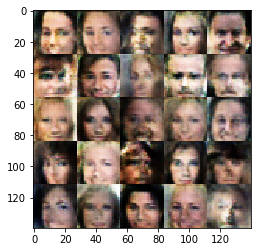

2017-08-07 06:26:20: Epoch: 0 batch_i: 2127 d_loss=1.4318075 g_loss=0.8533908 rate=1.5014767batches/s
2017-08-07 06:26:17: Epoch: 0 batch_i: 2143 d_loss=1.3687974 g_loss=0.8866576 rate=1.5030363batches/s
2017-08-07 06:26:17: Epoch: 0 batch_i: 2159 d_loss=1.3877652 g_loss=0.8811004 rate=1.5031265batches/s
2017-08-07 06:26:14: Epoch: 0 batch_i: 2175 d_loss=1.3915225 g_loss=0.8710636 rate=1.5049604batches/s


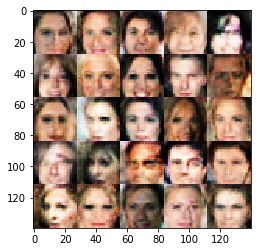

2017-08-07 06:26:14: Epoch: 0 batch_i: 2191 d_loss=1.3657923 g_loss=0.8776349 rate=1.5049959batches/s
2017-08-07 06:26:15: Epoch: 0 batch_i: 2207 d_loss=1.3700294 g_loss=0.8428564 rate=1.5041335batches/s
2017-08-07 06:26:12: Epoch: 0 batch_i: 2223 d_loss=1.3626676 g_loss=0.8501132 rate=1.5060277batches/s
2017-08-07 06:26:10: Epoch: 0 batch_i: 2239 d_loss=1.3955629 g_loss=0.8624956 rate=1.5070733batches/s


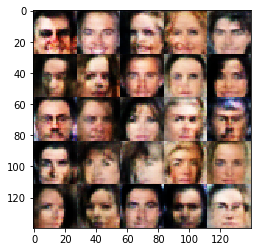

2017-08-07 06:26:09: Epoch: 0 batch_i: 2255 d_loss=1.3925301 g_loss=0.8888677 rate=1.5073942batches/s
2017-08-07 06:26:07: Epoch: 0 batch_i: 2271 d_loss=1.4385480 g_loss=0.8106878 rate=1.5088031batches/s
2017-08-07 06:26:15: Epoch: 0 batch_i: 2287 d_loss=1.4041522 g_loss=0.8812994 rate=1.5043323batches/s
2017-08-07 06:26:12: Epoch: 0 batch_i: 2303 d_loss=1.3951616 g_loss=0.8500400 rate=1.5057810batches/s


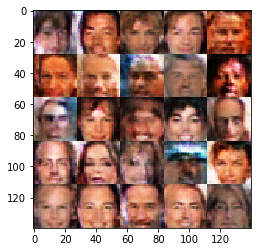

2017-08-07 06:26:12: Epoch: 0 batch_i: 2319 d_loss=1.3883214 g_loss=0.8287687 rate=1.5056490batches/s
2017-08-07 06:26:11: Epoch: 0 batch_i: 2335 d_loss=1.4444733 g_loss=0.8405234 rate=1.5065978batches/s
2017-08-07 06:26:09: Epoch: 0 batch_i: 2351 d_loss=1.3794284 g_loss=0.8473735 rate=1.5075618batches/s
2017-08-07 06:26:07: Epoch: 0 batch_i: 2367 d_loss=1.3709688 g_loss=0.8232981 rate=1.5087494batches/s


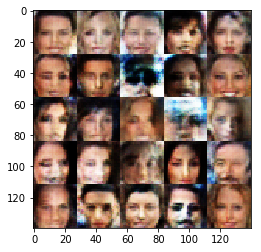

2017-08-07 06:26:06: Epoch: 0 batch_i: 2383 d_loss=1.3657061 g_loss=0.8515106 rate=1.5092468batches/s
2017-08-07 06:26:05: Epoch: 0 batch_i: 2399 d_loss=1.3819910 g_loss=0.8866633 rate=1.5094589batches/s
2017-08-07 06:26:06: Epoch: 0 batch_i: 2415 d_loss=1.3904171 g_loss=0.8120809 rate=1.5090886batches/s
2017-08-07 06:26:04: Epoch: 0 batch_i: 2431 d_loss=1.3461210 g_loss=0.8381841 rate=1.5103473batches/s


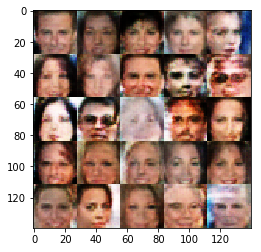

2017-08-07 06:26:03: Epoch: 0 batch_i: 2447 d_loss=1.3893696 g_loss=0.8553489 rate=1.5105029batches/s
2017-08-07 06:26:04: Epoch: 0 batch_i: 2463 d_loss=1.4088339 g_loss=0.8425555 rate=1.5102315batches/s
2017-08-07 06:26:01: Epoch: 0 batch_i: 2479 d_loss=1.3730172 g_loss=0.8242000 rate=1.5118457batches/s
2017-08-07 06:26:01: Epoch: 0 batch_i: 2495 d_loss=1.4159868 g_loss=0.8578291 rate=1.5119398batches/s


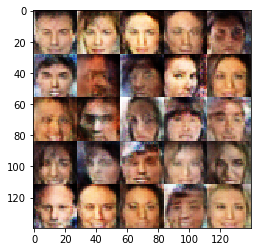

2017-08-07 06:25:59: Epoch: 0 batch_i: 2511 d_loss=1.3839309 g_loss=0.8167283 rate=1.5127270batches/s
2017-08-07 06:25:58: Epoch: 0 batch_i: 2527 d_loss=1.3818023 g_loss=0.8326303 rate=1.5135700batches/s
2017-08-07 06:25:55: Epoch: 0 batch_i: 2543 d_loss=1.3873992 g_loss=0.8244475 rate=1.5149607batches/s
2017-08-07 06:25:55: Epoch: 0 batch_i: 2559 d_loss=1.3447356 g_loss=0.8626758 rate=1.5149181batches/s


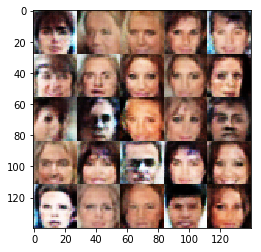

2017-08-07 06:25:55: Epoch: 0 batch_i: 2575 d_loss=1.3722370 g_loss=0.8220185 rate=1.5148333batches/s
2017-08-07 06:25:53: Epoch: 0 batch_i: 2591 d_loss=1.3839869 g_loss=0.8041375 rate=1.5162843batches/s
2017-08-07 06:25:51: Epoch: 0 batch_i: 2607 d_loss=1.3843758 g_loss=0.8474606 rate=1.5173134batches/s
2017-08-07 06:25:49: Epoch: 0 batch_i: 2623 d_loss=1.3789924 g_loss=0.8181101 rate=1.5182594batches/s


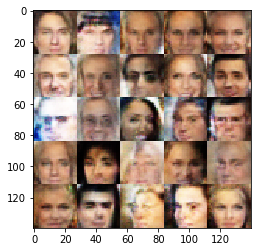

2017-08-07 06:25:47: Epoch: 0 batch_i: 2639 d_loss=1.3725929 g_loss=0.8047677 rate=1.5192972batches/s
2017-08-07 06:25:47: Epoch: 0 batch_i: 2655 d_loss=1.3944784 g_loss=0.8223094 rate=1.5194077batches/s
2017-08-07 06:25:45: Epoch: 0 batch_i: 2671 d_loss=1.3770590 g_loss=0.8689784 rate=1.5204513batches/s
2017-08-07 06:25:42: Epoch: 0 batch_i: 2687 d_loss=1.3634859 g_loss=0.8259317 rate=1.5221264batches/s


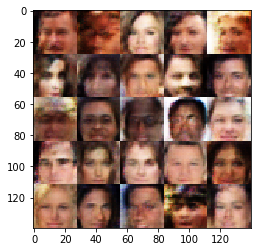

2017-08-07 06:25:42: Epoch: 0 batch_i: 2703 d_loss=1.3835083 g_loss=0.8549714 rate=1.5221129batches/s
2017-08-07 06:25:40: Epoch: 0 batch_i: 2719 d_loss=1.3840935 g_loss=0.8647060 rate=1.5232947batches/s
2017-08-07 06:25:39: Epoch: 0 batch_i: 2735 d_loss=1.3807789 g_loss=0.8502663 rate=1.5240789batches/s
2017-08-07 06:25:40: Epoch: 0 batch_i: 2751 d_loss=1.4138350 g_loss=0.8644768 rate=1.5235633batches/s


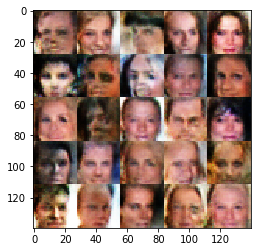

2017-08-07 06:25:38: Epoch: 0 batch_i: 2767 d_loss=1.3711759 g_loss=0.8749989 rate=1.5244371batches/s
2017-08-07 06:25:38: Epoch: 0 batch_i: 2783 d_loss=1.3993165 g_loss=0.8259218 rate=1.5244555batches/s
2017-08-07 06:25:37: Epoch: 0 batch_i: 2799 d_loss=1.3862634 g_loss=0.8819934 rate=1.5250217batches/s
2017-08-07 06:25:36: Epoch: 0 batch_i: 2815 d_loss=1.3579210 g_loss=0.8557963 rate=1.5255232batches/s


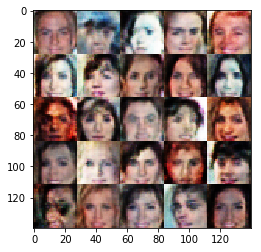

2017-08-07 06:25:35: Epoch: 0 batch_i: 2831 d_loss=1.3767369 g_loss=0.8497368 rate=1.5262501batches/s
2017-08-07 06:25:33: Epoch: 0 batch_i: 2847 d_loss=1.3709034 g_loss=0.8069088 rate=1.5270743batches/s
2017-08-07 06:25:34: Epoch: 0 batch_i: 2863 d_loss=1.3819394 g_loss=0.8170935 rate=1.5267455batches/s
2017-08-07 06:25:31: Epoch: 0 batch_i: 2879 d_loss=1.3540988 g_loss=0.8241909 rate=1.5282175batches/s


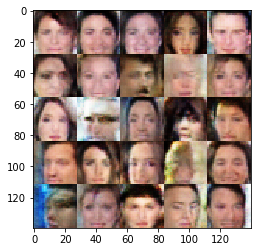

2017-08-07 06:25:31: Epoch: 0 batch_i: 2895 d_loss=1.3524196 g_loss=0.8509044 rate=1.5284566batches/s
2017-08-07 06:25:29: Epoch: 0 batch_i: 2911 d_loss=1.3863405 g_loss=0.8013395 rate=1.5294714batches/s
2017-08-07 06:25:29: Epoch: 0 batch_i: 2927 d_loss=1.4196982 g_loss=0.8527537 rate=1.5295889batches/s
2017-08-07 06:25:29: Epoch: 0 batch_i: 2943 d_loss=1.3781531 g_loss=0.8212707 rate=1.5294362batches/s


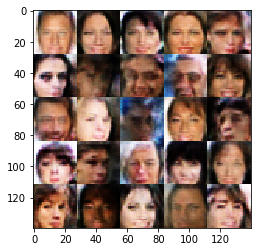

2017-08-07 06:25:27: Epoch: 0 batch_i: 2959 d_loss=1.3819256 g_loss=0.8046003 rate=1.5304420batches/s
2017-08-07 06:25:25: Epoch: 0 batch_i: 2975 d_loss=1.3692322 g_loss=0.8827788 rate=1.5315707batches/s
2017-08-07 06:25:23: Epoch: 0 batch_i: 2991 d_loss=1.4445440 g_loss=0.8795589 rate=1.5328171batches/s
2017-08-07 06:25:24: Epoch: 0 batch_i: 3007 d_loss=1.3894835 g_loss=0.8526996 rate=1.5322725batches/s


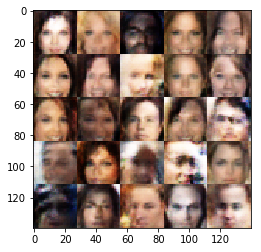

2017-08-07 06:25:22: Epoch: 0 batch_i: 3023 d_loss=1.3505614 g_loss=0.8394620 rate=1.5333447batches/s
2017-08-07 06:25:22: Epoch: 0 batch_i: 3039 d_loss=1.3873079 g_loss=0.8501157 rate=1.5331011batches/s
2017-08-07 06:25:20: Epoch: 0 batch_i: 3055 d_loss=1.3790252 g_loss=0.7986158 rate=1.5341776batches/s
2017-08-07 06:25:18: Epoch: 0 batch_i: 3071 d_loss=1.3845222 g_loss=0.8309844 rate=1.5357373batches/s


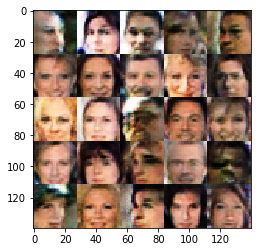

2017-08-07 06:25:17: Epoch: 0 batch_i: 3087 d_loss=1.3628314 g_loss=0.8277231 rate=1.5358486batches/s
2017-08-07 06:25:15: Epoch: 0 batch_i: 3103 d_loss=1.3761413 g_loss=0.7997922 rate=1.5370162batches/s
2017-08-07 06:25:13: Epoch: 0 batch_i: 3119 d_loss=1.3696280 g_loss=0.8494968 rate=1.5382533batches/s
2017-08-07 06:25:13: Epoch: 0 batch_i: 3135 d_loss=1.3888910 g_loss=0.7993199 rate=1.5380494batches/s


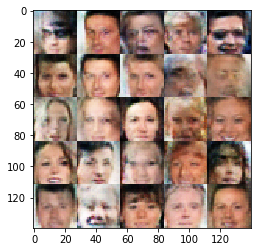

2017-08-07 06:25:12: Epoch: 0 batch_i: 3151 d_loss=1.4216423 g_loss=0.8401333 rate=1.5386709batches/s
2017-08-07 06:25:11: Epoch: 0 batch_i: 3167 d_loss=1.4081302 g_loss=0.8209606 rate=1.5394799batches/s
2017-08-07 06:25:09: Epoch: 0 batch_i: 3183 d_loss=1.3892894 g_loss=0.8716472 rate=1.5405387batches/s
2017-08-07 06:25:08: Epoch: 0 batch_i: 3199 d_loss=1.4236710 g_loss=0.8466331 rate=1.5412907batches/s


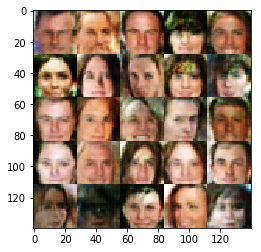

2017-08-07 06:25:07: Epoch: 0 batch_i: 3215 d_loss=1.3805482 g_loss=0.7906152 rate=1.5418452batches/s
2017-08-07 06:25:05: Epoch: 0 batch_i: 3231 d_loss=1.3831763 g_loss=0.8372712 rate=1.5428169batches/s
2017-08-07 06:25:04: Epoch: 0 batch_i: 3247 d_loss=1.3795710 g_loss=0.7973376 rate=1.5432107batches/s
2017-08-07 06:25:04: Epoch: 0 batch_i: 3263 d_loss=1.3840774 g_loss=0.7721837 rate=1.5435987batches/s


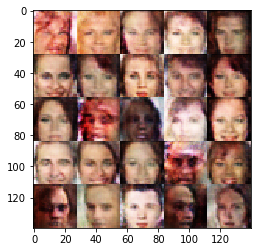

2017-08-07 06:25:03: Epoch: 0 batch_i: 3279 d_loss=1.3982258 g_loss=0.7832085 rate=1.5438040batches/s
2017-08-07 06:25:01: Epoch: 0 batch_i: 3295 d_loss=1.3631238 g_loss=0.8532802 rate=1.5450935batches/s
2017-08-07 06:25:01: Epoch: 0 batch_i: 3311 d_loss=1.3822596 g_loss=0.8355771 rate=1.5450970batches/s
2017-08-07 06:24:59: Epoch: 0 batch_i: 3327 d_loss=1.3579839 g_loss=0.8506767 rate=1.5460197batches/s


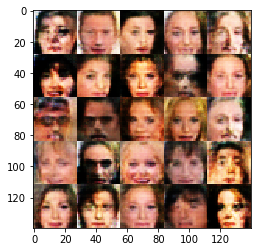

2017-08-07 06:24:58: Epoch: 0 batch_i: 3343 d_loss=1.3880622 g_loss=0.8223786 rate=1.5468735batches/s
2017-08-07 06:24:58: Epoch: 0 batch_i: 3359 d_loss=1.3599194 g_loss=0.8065025 rate=1.5468188batches/s
2017-08-07 06:24:56: Epoch: 0 batch_i: 3375 d_loss=1.3752697 g_loss=0.8254840 rate=1.5479707batches/s
2017-08-07 06:24:56: Epoch: 0 batch_i: 3391 d_loss=1.3902274 g_loss=0.8605736 rate=1.5480793batches/s


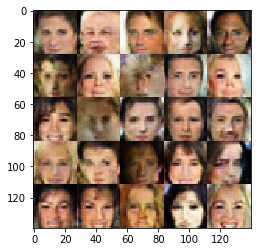

2017-08-07 06:24:55: Epoch: 0 batch_i: 3407 d_loss=1.3883011 g_loss=0.8075997 rate=1.5486682batches/s
2017-08-07 06:24:53: Epoch: 0 batch_i: 3423 d_loss=1.3681303 g_loss=0.8018295 rate=1.5494397batches/s
2017-08-07 06:24:52: Epoch: 0 batch_i: 3439 d_loss=1.3877573 g_loss=0.8109893 rate=1.5500472batches/s
2017-08-07 06:24:51: Epoch: 0 batch_i: 3455 d_loss=1.3994728 g_loss=0.8313335 rate=1.5508911batches/s


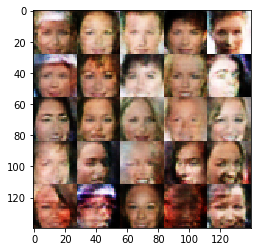

2017-08-07 06:24:49: Epoch: 0 batch_i: 3471 d_loss=1.3799500 g_loss=0.8220190 rate=1.5519186batches/s
2017-08-07 06:24:49: Epoch: 0 batch_i: 3487 d_loss=1.3702545 g_loss=0.8100652 rate=1.5520352batches/s
2017-08-07 06:24:48: Epoch: 0 batch_i: 3503 d_loss=1.3549943 g_loss=0.8542869 rate=1.5527200batches/s
2017-08-07 06:24:47: Epoch: 0 batch_i: 3519 d_loss=1.3714652 g_loss=0.8316061 rate=1.5527674batches/s


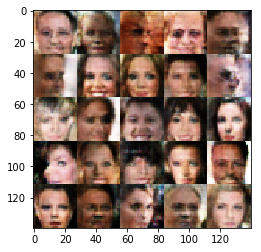

2017-08-07 06:24:46: Epoch: 0 batch_i: 3535 d_loss=1.3704401 g_loss=0.8286104 rate=1.5534370batches/s
2017-08-07 06:24:45: Epoch: 0 batch_i: 3551 d_loss=1.3905549 g_loss=0.8574955 rate=1.5541935batches/s
2017-08-07 06:24:45: Epoch: 0 batch_i: 3567 d_loss=1.3638746 g_loss=0.8418734 rate=1.5539316batches/s
2017-08-07 06:24:44: Epoch: 0 batch_i: 3583 d_loss=1.3993444 g_loss=0.8211043 rate=1.5548031batches/s


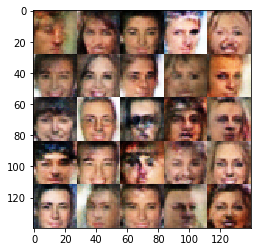

2017-08-07 06:24:45: Epoch: 0 batch_i: 3599 d_loss=1.4059327 g_loss=0.8507802 rate=1.5539449batches/s
2017-08-07 06:24:43: Epoch: 0 batch_i: 3615 d_loss=1.3861268 g_loss=0.8434414 rate=1.5550830batches/s
2017-08-07 06:24:42: Epoch: 0 batch_i: 3631 d_loss=1.3792380 g_loss=0.8402520 rate=1.5559625batches/s
2017-08-07 06:24:40: Epoch: 0 batch_i: 3647 d_loss=1.3805081 g_loss=0.8198339 rate=1.5569906batches/s


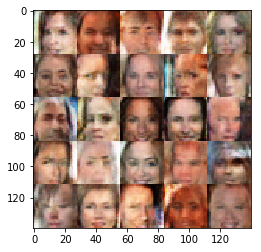

2017-08-07 06:24:41: Epoch: 0 batch_i: 3663 d_loss=1.4066784 g_loss=0.8245867 rate=1.5564062batches/s
2017-08-07 06:24:48: Epoch: 0 batch_i: 3679 d_loss=1.3929293 g_loss=0.8206820 rate=1.5524879batches/s
2017-08-07 06:24:56: Epoch: 0 batch_i: 3695 d_loss=1.4002526 g_loss=0.8618731 rate=1.5477917batches/s
2017-08-07 06:25:05: Epoch: 0 batch_i: 3711 d_loss=1.3585418 g_loss=0.8564507 rate=1.5427275batches/s


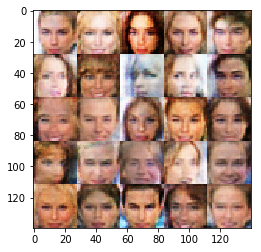

2017-08-07 06:25:15: Epoch: 0 batch_i: 3727 d_loss=1.3771521 g_loss=0.8424768 rate=1.5373462batches/s
2017-08-07 06:25:23: Epoch: 0 batch_i: 3743 d_loss=1.3888104 g_loss=0.8409812 rate=1.5328496batches/s
2017-08-07 06:25:31: Epoch: 0 batch_i: 3759 d_loss=1.3991222 g_loss=0.8193151 rate=1.5283977batches/s
2017-08-07 06:25:32: Epoch: 0 batch_i: 3775 d_loss=1.4124467 g_loss=0.8527939 rate=1.5278050batches/s


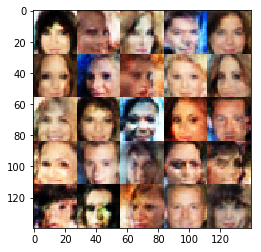

2017-08-07 06:25:33: Epoch: 0 batch_i: 3791 d_loss=1.3864754 g_loss=0.8412019 rate=1.5273388batches/s
2017-08-07 06:25:32: Epoch: 0 batch_i: 3807 d_loss=1.3616039 g_loss=0.8208551 rate=1.5277274batches/s
2017-08-07 06:25:31: Epoch: 0 batch_i: 3823 d_loss=1.3851058 g_loss=0.8365939 rate=1.5280351batches/s
2017-08-07 06:25:29: Epoch: 0 batch_i: 3839 d_loss=1.3782973 g_loss=0.8070266 rate=1.5291616batches/s


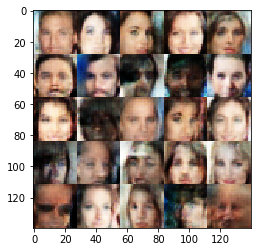

2017-08-07 06:25:31: Epoch: 0 batch_i: 3855 d_loss=1.3916566 g_loss=0.8250455 rate=1.5284804batches/s
2017-08-07 06:25:30: Epoch: 0 batch_i: 3871 d_loss=1.3732719 g_loss=0.8356469 rate=1.5287148batches/s
2017-08-07 06:25:29: Epoch: 0 batch_i: 3887 d_loss=1.3815268 g_loss=0.8113691 rate=1.5291485batches/s
2017-08-07 06:25:27: Epoch: 0 batch_i: 3903 d_loss=1.3864366 g_loss=0.8343602 rate=1.5302509batches/s


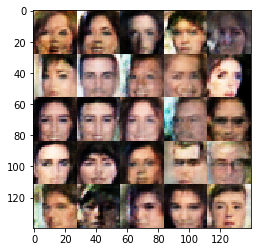

2017-08-07 06:25:28: Epoch: 0 batch_i: 3919 d_loss=1.3660296 g_loss=0.8386508 rate=1.5300294batches/s
2017-08-07 06:25:27: Epoch: 0 batch_i: 3935 d_loss=1.3664961 g_loss=0.8100798 rate=1.5306497batches/s
2017-08-07 06:25:26: Epoch: 0 batch_i: 3951 d_loss=1.3858355 g_loss=0.8458357 rate=1.5311599batches/s
2017-08-07 06:25:25: Epoch: 0 batch_i: 3967 d_loss=1.3804305 g_loss=0.8114691 rate=1.5313232batches/s


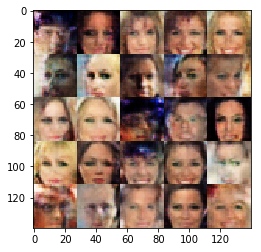

2017-08-07 06:25:24: Epoch: 0 batch_i: 3983 d_loss=1.4082053 g_loss=0.7768685 rate=1.5320029batches/s
2017-08-07 06:25:22: Epoch: 0 batch_i: 3999 d_loss=1.3924811 g_loss=0.8297173 rate=1.5330577batches/s
2017-08-07 06:25:22: Epoch: 0 batch_i: 4015 d_loss=1.3791015 g_loss=0.8291625 rate=1.5335247batches/s
2017-08-07 06:25:20: Epoch: 0 batch_i: 4031 d_loss=1.3716255 g_loss=0.8144926 rate=1.5343276batches/s


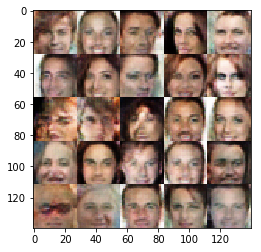

2017-08-07 06:25:23: Epoch: 0 batch_i: 4047 d_loss=1.3761904 g_loss=0.8393450 rate=1.5326158batches/s
2017-08-07 06:25:21: Epoch: 0 batch_i: 4063 d_loss=1.3746364 g_loss=0.8296688 rate=1.5337024batches/s
2017-08-07 06:25:20: Epoch: 0 batch_i: 4079 d_loss=1.3786405 g_loss=0.8707329 rate=1.5341819batches/s
2017-08-07 06:25:19: Epoch: 0 batch_i: 4095 d_loss=1.3810271 g_loss=0.8445406 rate=1.5348621batches/s


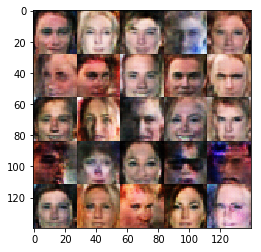

2017-08-07 06:25:19: Epoch: 0 batch_i: 4111 d_loss=1.3876915 g_loss=0.8048546 rate=1.5350021batches/s
2017-08-07 06:25:18: Epoch: 0 batch_i: 4127 d_loss=1.4079062 g_loss=0.8522723 rate=1.5352259batches/s
2017-08-07 06:25:17: Epoch: 0 batch_i: 4143 d_loss=1.3866596 g_loss=0.8014306 rate=1.5360373batches/s
2017-08-07 06:25:15: Epoch: 0 batch_i: 4159 d_loss=1.3889706 g_loss=0.8593502 rate=1.5370701batches/s


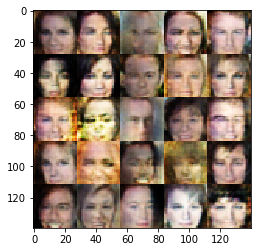

2017-08-07 06:25:15: Epoch: 0 batch_i: 4175 d_loss=1.3776996 g_loss=0.8376372 rate=1.5371414batches/s
2017-08-07 06:25:14: Epoch: 0 batch_i: 4191 d_loss=1.3664876 g_loss=0.8113393 rate=1.5378608batches/s
2017-08-07 06:25:12: Epoch: 0 batch_i: 4207 d_loss=1.3798897 g_loss=0.8369281 rate=1.5385987batches/s


In [136]:
batch_size = 48
z_dim = 100
learning_rate = 0.00025
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.